In [43]:
from functools import partial
import math
import urllib
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Introduction to Neural Networks and PyTorch
This notebook contains a brief introduction to PyTorch and three exercises.

# PyTorch Basics
[PyTorch](https://pytorch.org/) is a deep learning framework. PyTorch works with tensors which are multidimensional arrays similar to the ones used in NumPy. Since you have already used NumPy in previous exercises we will introduce PyTorch in terms of the main differences from NumPy:
* PyTorch can run operations on both CPU and hardware accelerators like GPUs. GPUs are particularly well suited for doing matrix multiplications which make up most of the computation in neural networks. Using GPUs can speed training up drastically, often on the order of ~100x for decently sized neural networks involving large matrix-matrix multiplications.
* PyTorch has automatic differentiation that allows it to compute the derivatives of most functions. You don't need to derive or implement the formulas for the gradients. This is especially useful for training neural networks through gradient descent.
* PyTorch provides implementations of various neural network components, dataloading utilities, and optimization tools, making it much easier to specify and train neural networks.

Make sure you have PyTorch installed ([see instructions](https://pytorch.org/get-started/locally/)) or run this notebook on Google colab (recommended if you don't have a GPU). You can import PyTorch as:

In [44]:
import torch

## PyTorch Tensors
Tensors (`torch.Tensor`) are similar to the multidimensional arrays used in NumPy (`numpy.ndarray`). The functions to create them often have similar names and arguments. We will use the function `torch.ones()` to highlight some of the differences between NumPy and PyTorch. The signatures for the two functions are:
```python
torch.ones(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False)
numpy.ones(shape, dtype=None, order='C', *, like=None)
```
* There are often subtle differences in the syntax. For example, the size argument of `torch.ones` can either accept a tuple or a variable number of integers but  NumPy only supports a tuple/list. Another common one is that PyTorch referes to `axis` as `dim` in operations such as `sum` and `mean`.
* Each tensor has a device associated with it and resides in the memory of that device. This is specified via the device argument used in all tensor creation ops. By default, this is the CPU (`device='cpu'`), but can also be the GPU (`device='cuda'`) or e.g. `device='cuda:0'` if you have many GPUs. All tensors involved in a given operation e.g. addition or matrix multiplication must recide on the same device. An existing tensor `T` can be moved to other devices in through commands such as `T.cpu()`, `T.cuda()`, `T.to(device='cuda')`. Each of these will return a new copy of the tensor on the target device.
* The default floating point precision in PyTorch is `torch.float32` but in NumPy this varies more and is often `numpy.float64`. If you are unfamiliar with floating point numbers, you can think of them as being equivalent to the scientific notation e.g. $\pm 1.23456 \cdot 10^{E}$, but in binary. Each format supports a specific range for the exponent $E$ and has a given number of significant digits. Float32 operations typically run significantly faster than float64 operations and require less memory, but are not as precise. For neural networks you should not use float64 unless you have a really good reason for it. In fact many operations in neural networks can be performed in even lower precision such as `torch.bfloat16` or `torch.float16`. These formats require less memory and run faster on hardware that supports it, but may require special tricks for training.
* Each tensor T in PyTorch can either have `T.requires_grad==True` or `T.requires_grad==False`. When requires_grad is True, PyTorch will keep track of operations involving this tensor in a structure referred to as a computation graph. PyTorch can backpropagate through a computation graph to compute gradients for the tensors involved.

## PyTorch Autograd
The automatic differentiation in PyTorch (autograd) records operations on tensors that have `requires_grad==True`. The following example demonstrates autograd:

In [45]:
A = torch.ones(4, requires_grad=True)  # A has shape (4,)
# Creates a tensor with the same shape, dtype and device as A with all values equal to 5
B = torch.full_like(A, 5)
C = A * B

# Note that C has a grad_fn, PyTorch remembers how this tensor was created and
# can differentiate through the op
print(C)

# True because it is derived from A which requires_grad
print(C.requires_grad)

tensor([5., 5., 5., 5.], grad_fn=<MulBackward0>)
True


In [46]:
scalar_loss = torch.sum(C)  # Create a scalar that we can compute derivatives for
scalar_loss.backward()  # Compute the gradients of all tensors with respect to scalar_loss

# 5 for all elements as expected
print(A.grad)
# None because we did not explicitly set requires_grad to True (not set by default using full_like)
print(B.grad)
# None because C is an intermediate tensor in the computation graph and not a leaf tensor
print(C.grad)

tensor([5., 5., 5., 5.])
None
None


In [47]:
torch.sum(2 * A).backward()
print(A.grad)  # Note that the gradients add up if we have multiple backward calls.

tensor([7., 7., 7., 7.])


Since gradients add upp with multiple backwards calls we have to remember to set the gradients to zero between iterations of gradient descent.

The gradient computation graph for tensors generally stores intermediate values required to compute the derivatives. By default calling `.backward()` on a tensor frees up these resources unless we specify `retain_graph=True` in the `backward` call. In many cases we have tensors that require gradients, such as model parameters, but we don't want to compute gradients e.g. when we are evaluating the model. In this case we can use `torch.no_grad()` which prevents torch from storing the computation graph and intermediate variables.

In [48]:
with torch.no_grad():
    D = 2 * A

print(D.requires_grad)  # False since D was computed inside torch.no_grad

False


Generally intermediate variables stored in computation graphs are also freed if subsequent tensors have been deleted (either explicitly or gone out of scope). Not using torch.no_grad, especially in loops where some tensors in the graph are not deleted (e.g. stored in a list), can result in a type of memory leak. Tensors can be detached from the computation graph through `T.detach()` which will return a reference to the tensor without the grad function or the computation graph.

## Resources
This wraps up our quick intro to PyTorch. There are many good resources available to learn PyTorch:
* [Deep Learning with PyTorch: a 60-minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

We recommend going through them later, especially if you will use PyTorch in your own projects or work. We will try to introduce concepts needed in the exercises as we go.

# Exercise 1
In this exercise you will define and train a fully connected neural network. As we saw in lecture, neural networks are general function approximators. Here we will train a neural network to approximate simple functions and visualize the results.

In this exercise we mostly use basic PyTorch operations instead of higher level packages such as `torch.nn`. We do this as a learning opportunity to go deeper into the workings of the neural network and PyTorch. In general we recommend the use of higher level implementations when possible and we will do so from exercise 2 onwards.

### Exercise 1.1 - Data Creation
We will be approximating the following 2d function:
$$ f_{true}(x_1, x_2) = \cos\left(10 \sqrt{x_1^2+x_2^2}\right) \cdot \exp{\left(-4 (x_1^2+x_2^2)\right)} $$
over the rectangle $(x_1, x_2) \in [-1:1]\times[-1:1]$

We provide a function below that samples a grid of points and returns an $N \times 2$ tensor $X$. Fill in the other function that computes $Y=f_{true}(X)$ according to the formula above.

Note that PyTorch has common math functions such as torch.sum, torch.cos etc. See more [here](https://pytorch.org/docs/stable/torch.html#math-operations).

In [49]:
def sample_grid(N_sqrt=100):
    """
    Returns an Nx2 tensor of grid points in [-1:1]x[-1:1].
    N=N_sqrt*N_sqrt.
    """
    x1 = torch.linspace(-1, 1, N_sqrt)
    x1_grid, x2_grid = torch.meshgrid(x1, x1, indexing="xy")
    X = torch.stack((x1_grid, x2_grid), -1).view(-1, 2)
    return X


def compute_f_true(X):
    """
    Returns Y=f_true(X)
    X is an Nx2 vector, Y is an Nx1 vector
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    R = torch.sqrt((X**2).sum(dim=1))
    Y = torch.cos(10*R)*torch.exp(-4  *R**2)
    return Y

### Exercise 1.2 - Model Definition
In this part we will create a simple model function for a ReLU fully connected network. We break the implementation down into several functions.

We assume the model has $L$ layers, an input dimension of 2, and output dimension of 1.
The inputs to the model are $X_0$ an $N \times 2$ matrix.
We use $K_{i}$ to denote the number of units in the $i$-th layer (i.e. their width or dimension, $i=1$ is the first layer). We assume the width of all the hidden layers (every layer except the last one) is constant, $K_i=K$. We set $K_0=2$ and $K_{L}=1$ corresponding to the number of input features and the dimension of the output.

Layer $i$ computes the following:
$$X_{i} = \phi(X_{i-1} W_{i} + b_{i})$$
Where $\phi=ReLU$ for all layers except the last one where it is identity, $W_{i}$ is a $K_{i-1} \times K_{i}$ matrix and $b_{i}$ is a bias vector with $K_{i}$ elements.

The first function `get_model_weights(L, K)` will create the weight and bias tensors. It takes in $L$ and $K$ and returns a list of $L$ matrices and a separate list of $L$ biases corresponding the layers in order.
* The biases should be set to zero, have dtype=torch.float32 and have requires_grad=True.
* The matrices should be initialized with an element-wise normal distribution with mean zero and standard deviation $\sqrt{2/K_{i-1}}$ where $K_{i-1}$ is the width of the input to the layer. This initialization strategy is called either Kaiming He initialization and aims to preserve the variance of activations on the forward pass accounting for a ReLU non-linearity. The weight matrices should also have dtype=torch.float32 and requires_grad=True.
* Note that you might need to create the weights in a couple of steps. Make sure that the weights returned have requires_grad=True and are not intermediate tensors in a computation graph, i.e. they are not derived from other tensors with requires_grad=True. PyTorch has [various functions](https://pytorch.org/docs/stable/torch.html#random-sampling) to sample random tensors.

The second function `predict(X, weights, biases)` takes in the inputs $X$ (i.e. $X_0$) as well as the list of weights and biases created by `get_model_weights`. It computes the output of the neural network according to the formula above. Here [torch.clamp](https://pytorch.org/docs/stable/generated/torch.clamp.html), [torch.mm](https://pytorch.org/docs/stable/generated/torch.mm.html) and/or the `@` operator could be useful.

In [50]:
def get_model_weights(L, K, device):
    weights = []
    biases = []

    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: Create the weights, biases and add them to the lists
    # ***************************************************
    for idx in range(L):
        K_in = 2 if idx == 0 else K
        K_out = 1 if idx ==L-1 else K
        weight = torch.randn((K_in, K_out), device=device) * (2 / K_in)**0.5
        weight.requires_grad = True
        weights.append(weight)
        biases.append(torch.zeros(K_out, requires_grad=True, device=device))
    return weights, biases


def predict(X, weights, biases):
    assert len(weights) == len(biases)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: Compute a forward pass through the network
    # ***************************************************
    for layer_idx in range(len(weights)):
        X = X @ weights[layer_idx] + biases[layer_idx]
        if layer_idx < len(weights)-1:
            X = torch.clamp(X, min==0.0)
    return X

### Exercise 1.3 - Training Loop
In this part we write a function that trains the model for a given number of steps.
We will use full-batch gradient descent with the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (using the PyTorch implementation).
The Adam optimizer performes a slightly modified version of gradient descent using a couple of tricks that make it more robust to hyperparameters than standard gradient descent (the link above has the algorithmic details).
Typically some hyperparameter tuning is still required, especially for the learning rate and weight decay (if used).
In this case the default hyperparameters should work quite well.

Fill in the missing details in the function below.
* The loss should be the MSE error (implemented without torch.nn). Make sure that your model predictions and Y_true have the same shape when you compare them.
* Note the use of optimizer.step and optimizer.zero_grad
* Note that the optimizer changes the weights in-place

In [51]:
def train_network(num_steps, weights, biases, X, Y_true, lr=1e-3, verbose=True):
    parameters = weights + biases
    optimizer = torch.optim.Adam(weights + biases, lr)
    losses = []
    for step in range(num_steps):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # ***************************************************
        Y = predict(X, weights, biases)
        loss = torch.mean(Y.flatten() - Y_true.flatten())**2
        # TODO: Use backpropagation on the loss
        loss.backward()
        losses.append(loss.item())
        if verbose and step % 100 == 0:
            print(f"step={step} - loss={loss.item():0.4f}")
        optimizer.step()
        optimizer.zero_grad()

    if verbose:
        plt.plot(losses)
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.show()

### Exercise 1.4 - Train the Network and Visualize the Results
Below we provide a function that creates the dataset, trains the model and plots the resulting predictions. Note the use of `torch.no_grad` when we compute the final predictions for the model.

Experiment with the depth and width of the network.
* How wide / deep does the network have to be to approximate this function well?
* In lecture we learned that the output of ReLU networks is picewise linear. Can you see evidence of this in the plots?
* We also provide an alternative function that is more complicated. How does the neural network fare on this one?

In [52]:
def plot_heatmap(X, Y, N_sqrt, mark_level=None):
    x1_grid = X[:, 0].reshape((N_sqrt, N_sqrt))
    x2_grid = X[:, 1].reshape((N_sqrt, N_sqrt))
    plt.pcolormesh(x1_grid, x2_grid, Y.reshape_as(x1_grid), cmap="bwr", vmin=-1, vmax=1)
    plt.axis([x1_grid.min(), x1_grid.max(), x2_grid.min(), x2_grid.max()])
    plt.colorbar()
    if mark_level is None:
        mark_level = float(Y.mean())
    if isinstance(mark_level, (int, float)):
        plt.contour(
            x1_grid,
            x2_grid,
            Y.reshape_as(x1_grid),
            levels=[mark_level],
            colors="k",
            linewidths=1,
        )
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")


def plot_cross_section(X, Y, value=0, **kwargs):
    x2 = X[:, 1]
    value_rounded = x2[torch.argmin(torch.abs(x2 - value))]
    mask = torch.isclose(X[:, 1], value_rounded)
    x1 = X[mask, 0]
    y = Y[mask]
    plt.plot(x1, y, **kwargs)


def get_alternative_data(N_sqrt):
    img_path = Path("./img.png")
    if not img_path.exists():
        imgURL = "https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl.png"
        urllib.request.urlretrieve(imgURL, img_path)

    img = -np.asarray(matplotlib.image.imread("img.png")).sum(axis=-1)
    rows = np.rint(np.linspace(0, img.shape[0] - 1, N_sqrt)).astype(np.int32)[::-1]
    cols = np.rint(np.linspace(0, img.shape[1] - 1, N_sqrt)).astype(np.int32)
    rows, cols = np.meshgrid(rows, cols, indexing="ij")
    X = sample_grid(N_sqrt)
    Y = img[rows.reshape(-1), cols.reshape(-1)]
    Y = Y - Y.min()
    Y = Y / Y.max()
    return X, torch.from_numpy(Y)

step=0 - loss=0.0275
step=100 - loss=0.0000
step=200 - loss=0.0000
step=300 - loss=0.0000
step=400 - loss=0.0000
step=500 - loss=0.0000
step=600 - loss=0.0000
step=700 - loss=0.0000
step=800 - loss=0.0000
step=900 - loss=0.0000


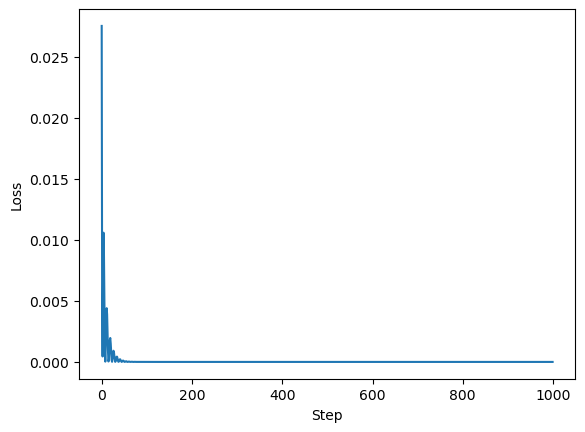

In [53]:
# TODO: Play around with these settings
N_sqrt = 100
D = 4
H = 32

# Alternative might require more steps, a wider network or other learning rates
alternative_dataset = False

# You can set this to 'cuda' if you have a GPU available.
# In this case the dataset and model is so small that we only expect a minimal speed difference.
device = torch.device("cpu")
steps = 1000
lr = 1e-3

# Create dataset and move to device (if needed)
if alternative_dataset:
    X, Y_true = get_alternative_data(N_sqrt)
    X = X.to(device)
    Y_true = Y_true.to(device)
else:
    X = sample_grid(N_sqrt).to(device)
    Y_true = compute_f_true(X).to(device)

# Create model
weights, biases = get_model_weights(D, H, device)
assert all(
    [p.requires_grad for p in weights + biases]
), "All model parameters should have requires_grad=True"
assert all(
    [p.is_leaf for p in weights + biases]
), "All model parameters must be leaf tensors"

# Train the model
train_network(steps, weights, biases, X, Y_true, lr)

# Compute the final model predictions
# Typically this would be on some sort of validation or test data
with torch.no_grad():
    Y_model = predict(X, weights, biases)

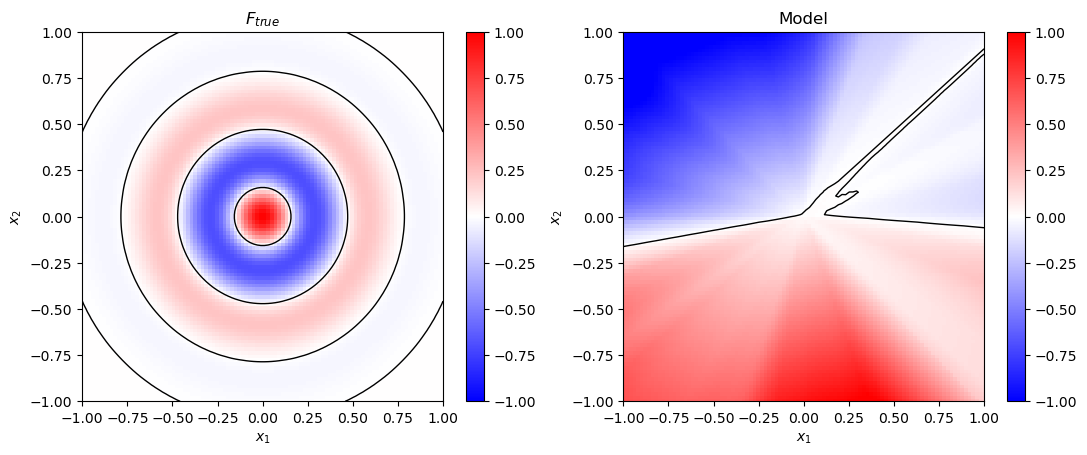

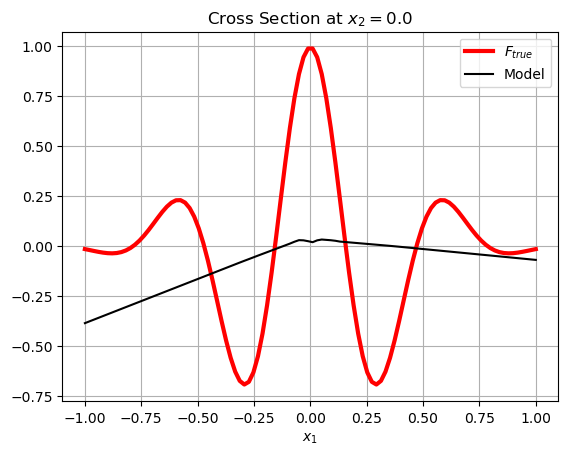

In [54]:
# Move things back to the CPU for plotting (if needed)
X = X.cpu()
Y_true = Y_true.cpu()
Y_model = Y_model.cpu()

plt.figure(figsize=(2 * 6.4, 4.8))
plt.subplot(121)
plot_heatmap(X, Y_true, N_sqrt, 0.5 if alternative_dataset else 0.0)
plt.title("$F_{true}$")
plt.subplot(122)
plot_heatmap(X, Y_model, N_sqrt, 0.5 if alternative_dataset else 0.0)
plt.title("Model")
plt.show()

plt.figure()
x2_value = 0.0
plot_cross_section(X, Y_true, x2_value, label="$F_{true}$", color="r", linewidth=3)
plot_cross_section(X, Y_model, x2_value, label="Model", color="k", ls="-")
plt.xlabel("$x_1$")
plt.title(f"Cross Section at $x_2={x2_value}$")
plt.grid()
plt.legend()
plt.show()

# Exercise 2 - Digit Classification
In this exercise you will build and train a neural network to classify handwritten digits in the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). The link contains information about the dataset including example images. There are 10 classes corresponding to digits from 0 through 9. Each image is 28x28 pixels and grayscale. We will be using a fully connected network so we flatten each element into a $d=784$ element vector. We will have one output for each class. We will use softmax to turn these outputs into probabilities for each class and the cross entropy with a one-hot encoding of the label as our loss.

## Exercise 2.1 - Model Creation
In this exercise you will use the higher level neural network functions in the `torch.nn`. A linear layer can be implemented using [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) and a ReLU with [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU). Our inputs to the network are a $n \times d$ vector, i.e. a minibatch of $n$ flattened images. We will use two hidden layers of width 128 and a final output layer with 10 features corrsponding to each class. The output shape of a layer with width $K$ is $n \times K$. 

Our PyTorch model is a class that inherits from [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). The module class provides various methods for keeping track of parameters and other nested modules such as the `torch.nn.Linear` layers we will use. Read through the code and fill in the missing details.

In [55]:
class MNIST_model(torch.nn.Module):
    # Models in PyTorch usually inherit from this Module
    def __init__(self):
        super().__init__()
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: Fill in the missing arguments here!
        # ***************************************************
        # raise NotImplementedError
        self.input_layer = torch.nn.Linear(784, 128)  # TODO
        self.input_phi = torch.nn.ReLU()
        self.layer1 = torch.nn.Linear(128, 128)  # TODO
        self.phi1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(128, 128)  # TODO
        self.phi2 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(128, 10)  # TODO

    def forward(self, Z):
        Z = torch.flatten(Z, 1)  # Flatten (n, 28, 28) to (n, 784)
        Z = self.input_layer(Z)
        Z = self.input_phi(Z)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: Fill in the rest of the forward pass
        # ***************************************************
        # raise NotImplementedError
        Z = self.layer1(Z)
        Z = self.phi1(Z)
        Z = self.layer2(Z)
        Z = self.phi2(Z)
        Z = self.output_layer(Z)
        return Z


## Exercise 2.2 - Training Script
Here we provide most of the functionality needed to train the model. Read through the code and fill in the missing details in train_epoch. Note that we use the Adam optimizer again.

In [56]:
from torchvision import datasets, transforms


def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()  # Important set model to train mode (affects dropout, batch norm etc)

    loss_history = []
    accuracy_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        # TODO: Move data and target to the specified device
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)  # TODO
        # TODO Backpropagate
        loss.backward()
        # TODO Optimizer step
        optimizer.step()
        # TODO Zero the gradients
        optimizer.zero_grad()
        # raise NotImplementedError

        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()

        loss_history.append(loss.item())
        accuracy_history.append(correct / len(data))

        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item()/len(data):0.2e} batch_acc={correct/len(data):0.3f}"
            )

    return loss_history, accuracy_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    return test_loss, correct / len(val_loader.dataset)


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)

        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        pred = np.split(pred.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        points.extend(zip(data, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points


def run_mnist_training(num_epochs, lr, batch_size, device="cpu"):
    # ===== Data Loading =====
    # The input images should be normalized to have zero mean, unit variance
    # We could also add data augmentation here if we wanted
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
    train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)

    # Here we use the official test set as a validation set
    # This is not a good practice (but quite common since it is easier to setup)
    val_set = datasets.MNIST("./data", train=False, transform=transform)

    # The dataloaders can run in separate threads and handle the actual data
    # reading, augmenting and forming mini-batches
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model = MNIST_model()
    model = model.to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.functional.cross_entropy

    # ===== Train Model =====
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(
            model, device, train_loader, optimizer, epoch, criterion
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)

        val_loss, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)
    plt.figure()
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.figure()
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # ===== Plot low/high loss predictions on validation set =====
    points = get_predictions(
        model,
        device,
        val_loader,
        partial(torch.nn.functional.cross_entropy, reduction="none"),
    )
    points.sort(key=lambda x: x[1])
    plt.figure(figsize=(15, 6))
    for k in range(5):
        plt.subplot(2, 5, k + 1)
        plt.imshow(points[k][0].reshape(28, 28), cmap="gray")
        plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
        plt.subplot(2, 5, 5 + k + 1)
        plt.imshow(points[-k - 1][0].reshape(28, 28), cmap="gray")
        plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")

## Exercise 2.3 - Train the model
Experiment with the learning rate and number of epochs and see how the accuracy is affected.

Train Epoch: 1-0 batch_loss=1.80e-02 batch_acc=0.094
Train Epoch: 1-46 batch_loss=2.54e-03 batch_acc=0.898
Train Epoch: 1-92 batch_loss=2.61e-03 batch_acc=0.898
Train Epoch: 1-138 batch_loss=2.01e-03 batch_acc=0.930
Train Epoch: 1-184 batch_loss=1.58e-03 batch_acc=0.953
Train Epoch: 1-230 batch_loss=1.66e-03 batch_acc=0.938
Train Epoch: 1-276 batch_loss=9.67e-04 batch_acc=0.953
Train Epoch: 1-322 batch_loss=1.64e-03 batch_acc=0.930
Train Epoch: 1-368 batch_loss=9.15e-04 batch_acc=0.953
Train Epoch: 1-414 batch_loss=8.38e-04 batch_acc=0.984
Train Epoch: 1-460 batch_loss=5.68e-04 batch_acc=0.977
Test set: Average loss: 0.1628, Accuracy: 9501/10000 (95%)
Train Epoch: 2-0 batch_loss=9.89e-04 batch_acc=0.969
Train Epoch: 2-46 batch_loss=9.14e-04 batch_acc=0.945
Train Epoch: 2-92 batch_loss=8.36e-04 batch_acc=0.953
Train Epoch: 2-138 batch_loss=1.12e-03 batch_acc=0.969
Train Epoch: 2-184 batch_loss=1.42e-03 batch_acc=0.945
Train Epoch: 2-230 batch_loss=1.65e-03 batch_acc=0.938
Train Epoch: 2

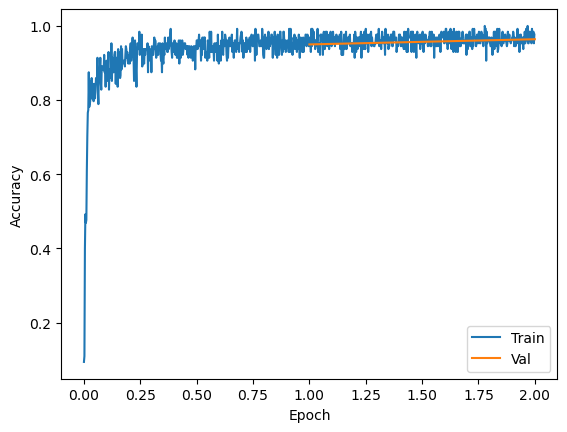

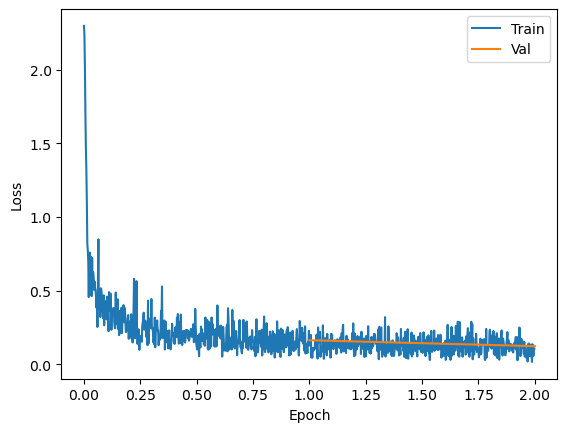

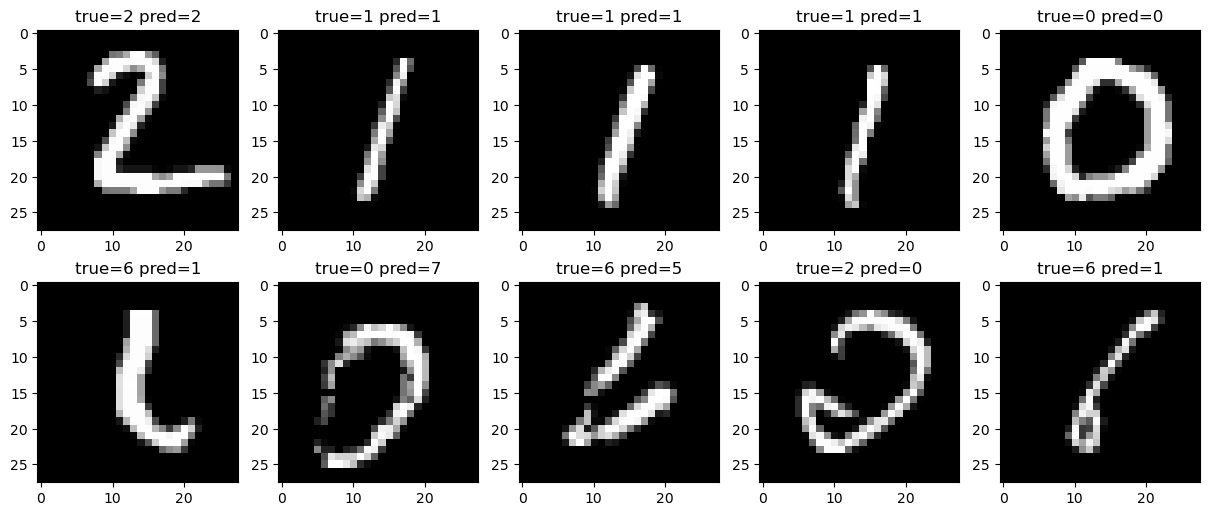

In [57]:
# TODO: Play around with these settings
lr = 5e-3
batch_size = 128
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_mnist_training(num_epochs, lr, batch_size, device)

# Exercise 3 - Weight Initialization and Activation/Gradient Magnitudes
In this exercise we will investigate how the activation and gradient magnitudes for different layers depend on the initialization of the weights and the activation function used. We will look at a fully connected network with depth 32 and a fixed width of 128 (including the input and output layers).

## Exercise 3.1 - Network Definition
Fill out the function below. It takes in the depth, width, and a string reflecting the type of activation used. It returns a model with depth nn.Linear layers with inputs and outputs of width, and has the specified activation function between them. The [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) class is very useful to create models that consist of a sequential application of modules i.e. models without branches.

In [58]:
def create_network_e3(depth=10, width=128, activation="relu"):
    if activation == "relu":
        activation_class = torch.nn.ReLU
    elif activation == "sigmoid":
        activation_class = torch.nn.Sigmoid
    elif activation == "tanh":
        activation_class = torch.nn.Tanh
    elif activation == "identity":
        activation_class = torch.nn.Identity
    else:
        raise ValueError(f"Unknown activation type {activation}")

    modules = []
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: Insert the nn.Linear and activation functions into the module list
    for i in range(depth-1):
        modules.append(torch.nn.Linear(width, width))
        modules.append(activation_class())
    modules.append(torch.nn.Linear(width, width))
    # Remember to call the activation_class to get an instance (not the class)
    # ***************************************************
    # raise NotImplementedError
    return torch.nn.Sequential(*modules)

## Exercise 3.2 - Initializing the weights
When PyTorch creates layers such as torch.nn.Linear it uses a default intialization strategy ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). Here we will manually change the value of the weights to follow a different strategy.

Fill in the function below that takes in the model and a desired scale factor for the weights.
Initialize the weights using [torch.nn.init.normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_) to have standard devation `scale_factor / math.sqrt(out_features)` where out_features is the number of ouput features (i.e. the width of the layer).
Initialize the biases to with zeros using [torch.nn.init.zeros_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.zeros_). Note that these operations change the weights in-place (indicated by the trailing underscore).

In [59]:
def initialize_weights_e3(model, scale_factor):
    for module in model.modules():
        if isinstance(module, torch.nn.Linear):
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: Initialize module.weight and module.bias
            # ***************************************************
            # raise NotImplementedError
            width = module.weight.shape[0]
            torch.nn.init.normal_(
                module.weight, mean=0, std = scale_factor/math.sqrt(width)
            )
            torch.nn.init.zeros_(module.bias)

# Exercise 3.3 - Experimenting with the scale factors
Ideally we want to find a `scale_factor` that keeps the norms of activations and gradients stable through the network. This is typically beneficial for optimization as well as numerical stability.

Below we provide code that plots the root-mean-square value of the pre-activations, deltas and gradients across the layers when the input and initial deltas are normally distributed.

Experiment with different scale factors for ReLU and sigmoid. Can you find a good value for ReLUs? What about sigmoids? Do you observe vanishing gradients for some initialization values?

In [60]:
from functools import partial


def get_values(model, width, N_samples=1):
    # Don't worry about the implementation of this
    layers = [m for m in model.modules() if isinstance(m, torch.nn.Linear)]
    num_layers = len(layers)
    outputs = [None] * (num_layers + 1)
    deltas = [None] * (num_layers + 1)
    bias_grads = [None] * num_layers
    weight_grads = [None] * num_layers
    hooks = []

    @torch.no_grad()
    def fwd_hook(module, input, output, idx):
        outputs[idx] = output.detach()

    @torch.no_grad()
    def bwd_hook(module, grad_input, grad_output, idx):
        deltas[idx] = grad_output[0].detach()

    for idx, m in enumerate(layers):
        hooks.append(m.register_forward_hook(partial(fwd_hook, idx=idx)))
        hooks.append(m.register_full_backward_hook(partial(bwd_hook, idx=idx)))

    X = torch.randn(N_samples, width, requires_grad=True)
    Y = model(X)
    deltaY = torch.randn_like(Y) / N_samples
    Y.backward(deltaY)

    with torch.no_grad():
        outputs[-1] = Y.detach()
        deltas[-1] = deltaY.detach()

        for idx, m in enumerate(layers):
            weight_grads[idx] = m.weight.grad.detach()
            bias_grads[idx] = m.bias.grad.detach()

    for hook in hooks:
        hook.remove()

    return outputs, deltas, weight_grads, bias_grads


@torch.no_grad()
def plot_values(outputs, deltas, weight_grads, bias_grads, metric_str="rms"):
    plt.figure(figsize=(6.4, 4.8))
    z_idx = np.arange(len(outputs))
    layer_idx = np.arange(len(weight_grads)) + 1

    if metric_str == "rms":
        # root-mean-square
        metric = lambda x_list: [torch.sqrt(torch.mean(x**2)) for x in x_list]
    elif metric_str == "mav":
        # mean absolute value
        metric = lambda x_list: [torch.mean(torch.abs(x)) for x in x_list]
    elif metric_str == "abs_q3":
        # third quartile
        metric = lambda x_list: [torch.quantile(torch.abs(x), 0.75) for x in x_list]
    else:
        raise ValueError(f"Unknown metric={metric_str}")

    plt.semilogy(z_idx, metric(outputs), label="Output (Z)")
    plt.semilogy(z_idx, metric(deltas), label="Delta")
    plt.semilogy(layer_idx, metric(weight_grads), label="Weight Grad")
    plt.semilogy(layer_idx, metric(bias_grads), label="Bias Grad")
    plt.grid()
    plt.xlabel("Layer")
    plt.ylabel(f"Metric Value ({metric_str})")
    plt.legend()
    plt.show()

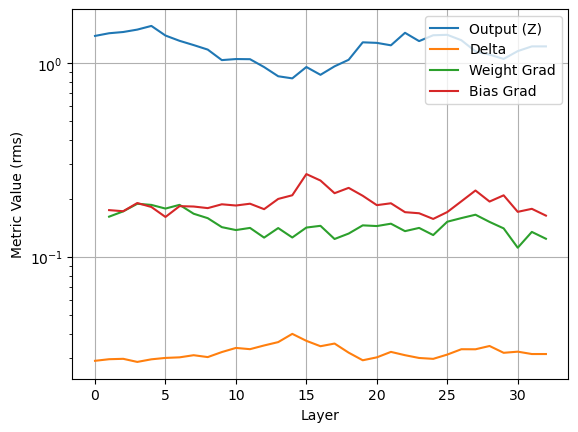

In [61]:
# TODO: Experiment with scale factors for relu, sigmoid, tanh, identity
# You can look at https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain for commonly used values
activation = "relu"
scale_factor = 1.414  # Default intialization if None

depth = 32
width = 128
N_samples = 32
model = create_network_e3(depth=depth, width=width, activation=activation)
if scale_factor is not None:
    initialize_weights_e3(model, scale_factor)

outputs, deltas, weight_grads, bias_grads = get_values(model, width, N_samples)
plot_values(outputs, deltas, weight_grads, bias_grads, "rms")